In [1]:
library(rstan)
library(here)
library(bayesplot)
library(ggfortify)
library(gridExtra)

# 計算の高速化
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

source(here("plotSSM.r"), encoding = "utf-8")


要求されたパッケージ StanHeaders をロード中です


rstan version 2.32.6 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


here() starts at /media/e595/Game/プロジェクト置き場/RとStanで始めるベイズ統計モデリング

This is bayesplot version 1.11.1

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting

要求されたパッケージ ggplot2 をロード中です



In [2]:
# データの読み込み
sales_df_4 <- read.csv(here("data", "5-6-1-sales-ts-4.csv"))
sales_df_4$date <- as.POSIXct(sales_df_4$date)
head(sales_df_4, n = 3)


,date,sales
,<dttm>,<dbl>
1,2010-01-01,81.1
2,2010-01-02,127.7
3,2010-01-03,119.5


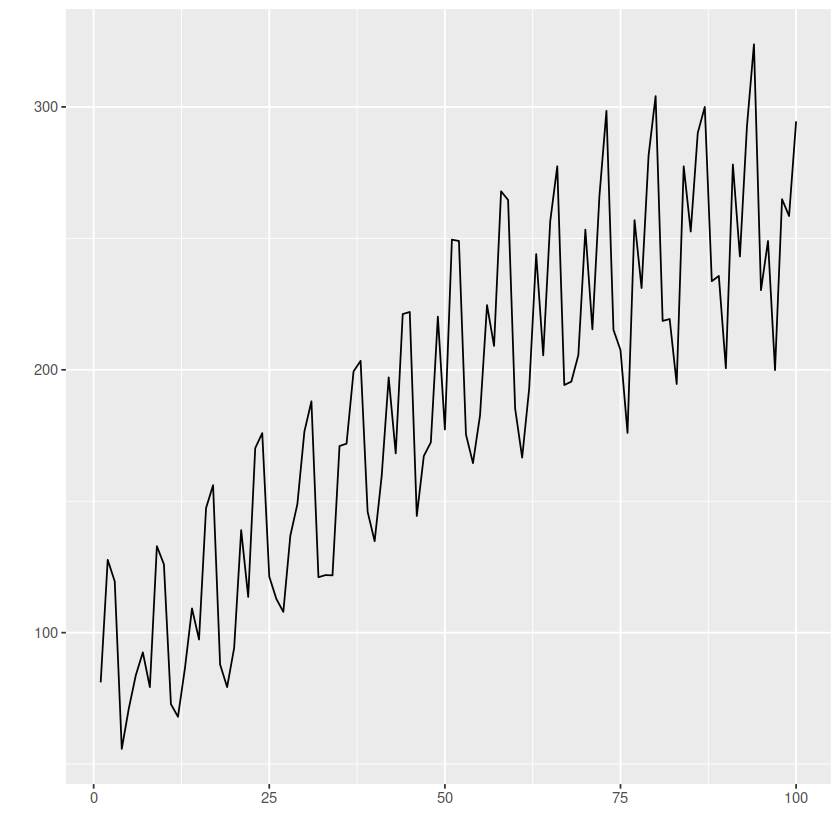

In [8]:
# 図示
autoplot(ts(sales_df_4[, -1]))


In [9]:
data_list <- list(
  y = sales_df_4$sales,
  T = nrow(sales_df_4)
)

basic_structural <- stan(
  file = here("5部", "5-6-1-basic-structural-time-series.stan"),
  data = data_list,
  seed = 1,
  iter = 8000,
  warmup = 2000,
  thin = 6,
  control = list(adapt_delta = 0.97, max_treedepth = 15)
)


Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


In [10]:
print(
  basic_structural,
  par = c("s_z", "s_s", "s_v", "lp__"),
  probs = c(0.025, 0.5, 0.975)
)


Inference for Stan model: anon_model.
4 chains, each with iter=8000; warmup=2000; thin=6; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean    sd    2.5%     50%   97.5% n_eff Rhat
s_z     0.25    0.01  0.11    0.11    0.22    0.52   411 1.01
s_s     4.17    0.02  0.89    2.58    4.11    6.08  2148 1.00
s_v     7.38    0.02  0.96    5.60    7.35    9.32  3079 1.00
lp__ -328.70    1.97 41.39 -413.17 -327.70 -253.21   443 1.01

Samples were drawn using NUTS(diag_e) at Sun Sep 15 12:07:56 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).



Divergences:


0 of 4000 iterations ended with a divergence.




Tree depth:


0 of 4000 iterations saturated the maximum tree depth of 15.




Energy:


E-BFMI indicated no pathological behavior.



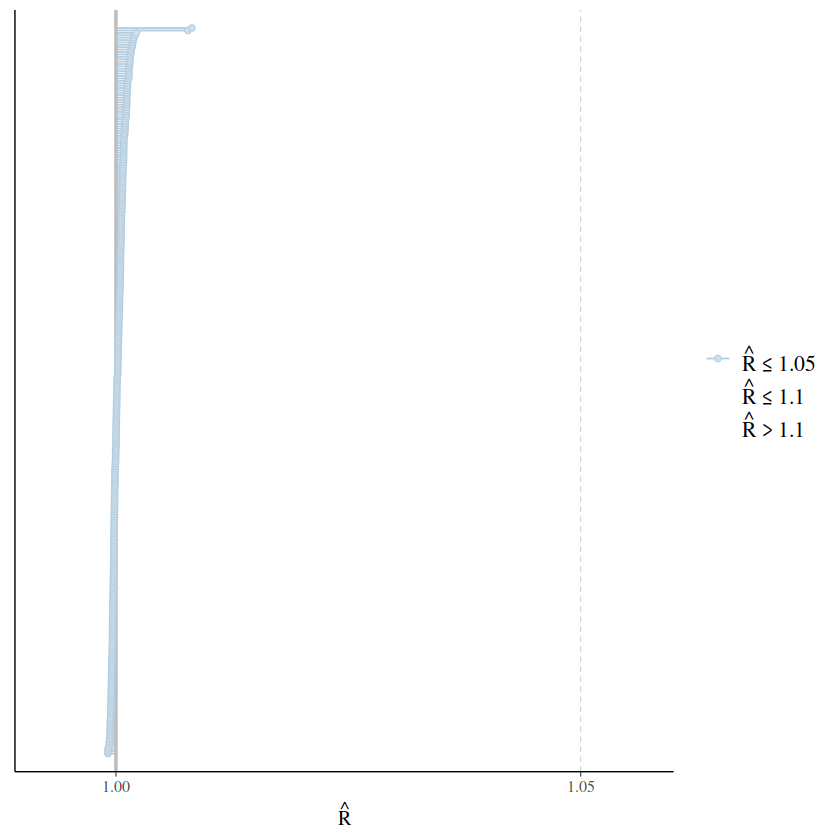

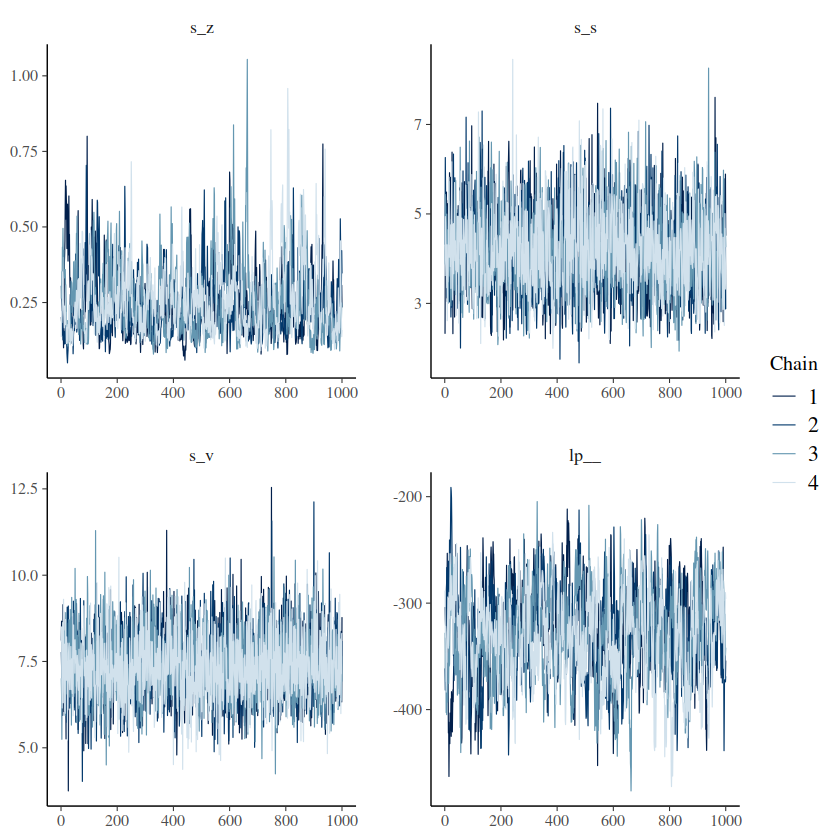

In [11]:
# 参考：収束の確認
mcmc_rhat(rhat(basic_structural))
check_hmc_diagnostics(basic_structural)

# 参考:トレースプロット
mcmc_sample <- rstan::extract(basic_structural, permuted = FALSE)
mcmc_trace(mcmc_sample, pars = c("s_z", "s_s", "s_v", "lp__"))


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


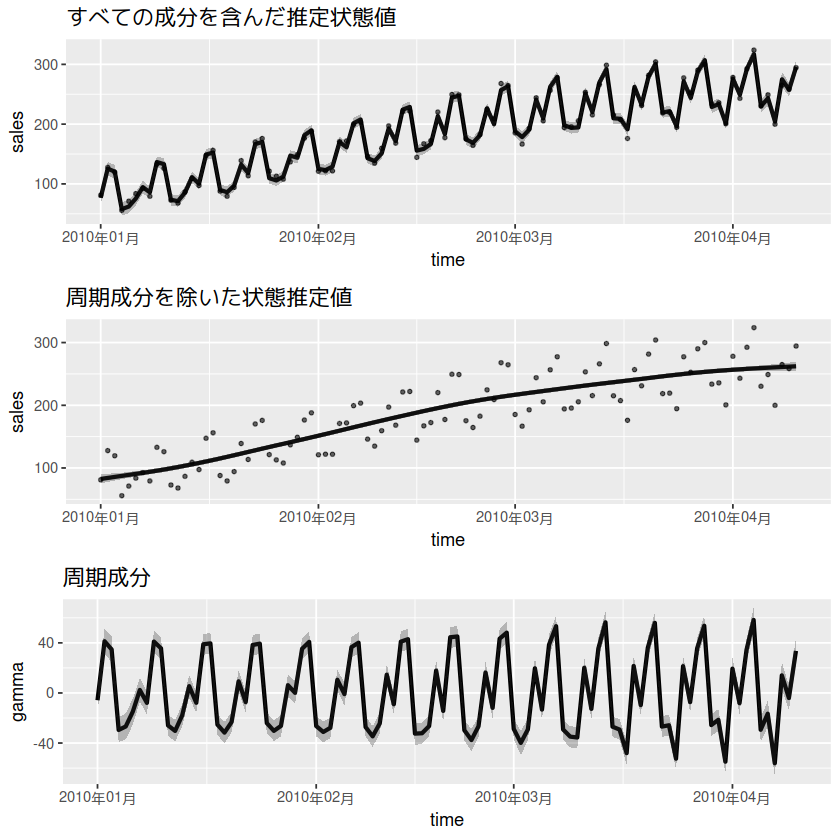

In [12]:
mcmc_sample <- rstan::extract(basic_structural)

p_all <- plotSSM(
  mcmc_sample = mcmc_sample,
  time_vec = sales_df_4$date,
  obs_vec = sales_df_4$sales,
  state_name = "alpha",
  graph_title = "すべての成分を含んだ推定状態値",
  y_label = "sales"
)

p_trend <- plotSSM(
  mcmc_sample = mcmc_sample,
  time_vec = sales_df_4$date,
  obs_vec = sales_df_4$sales,
  state_name = "mu",
  graph_title = "周期成分を除いた状態推定値",
  y_label = "sales"
)

p_cycle <- plotSSM(
  mcmc_sample = mcmc_sample,
  time_vec = sales_df_4$date,
  state_name = "gamma",
  graph_title = "周期成分",
  y_label = "gamma"
)

grid.arrange(p_all, p_trend, p_cycle)
